# 04 — Modeling: Insights & Actions

**Goal.** Build a small, honest forecaster for my daily productivity (`productivity_pct`) using behavioral signals (sleep, hydration, study context, etc.), with **time-aware** evaluation and **no label leakage**.


## 0) Preamble: paths, data, utils

In [59]:
# 0) Paths & imports
from pathlib import Path
import json, math, numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

def find_repo_root(start: Path) -> Path:
    cur = start.resolve()
    for _ in range(5):
        if (cur / "pyproject.toml").exists() or (cur / ".git").exists():
            return cur
        cur = cur.parent
    return start.resolve()

ROOT = find_repo_root(Path.cwd())
DATA    = ROOT / "data" / "interim"
REPORTS = ROOT / "notebooks" / "reports"
FIGS    = REPORTS / "figures"
MODELS  = ROOT / "models"
for p in [REPORTS, FIGS, MODELS]: p.mkdir(parents=True, exist_ok=True)

FEATURES = DATA / "features.parquet"
assert FEATURES.exists(), f"Missing {FEATURES}"
df = pd.read_parquet(FEATURES).sort_values("date").reset_index(drop=True)

TARGET = "productivity_pct"
assert TARGET in df.columns, f"{TARGET} missing"

def _rmse(y_true, y_pred):
    # Works on old and new scikit-learn
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))


def regression_report(y_true, y_pred):
    y_true = np.asarray(y_true, float); y_pred = np.asarray(y_pred, float)
    return {
        "MAE": round(mean_absolute_error(y_true, y_pred), 2),
        "RMSE": round(_rmse(y_true, y_pred), 2),
        "R2": round(r2_score(y_true, y_pred), 3),
    }

print("Loaded features:", df.shape)


Loaded features: (72, 103)


## 1) Temporal features: simple lags & 3-day rollups

In [60]:
# 1) Add simple temporal context
def add_temporal_features(dfin: pd.DataFrame) -> pd.DataFrame:
    d = dfin.copy()
    # choose a few stable drivers to lag/roll; adjust to your columns
    cand = [
        "sleep_duration_h", "deep_sleep_pct", "water_drank_l",
        "studied_at_home", "studied_at_school",
    ]
    present = [c for c in cand if c in d.columns]
    for c in present:
        d[f"{c}_lag1"] = d[c].shift(1)
        d[f"{c}_roll3_mean"] = d[c].rolling(3).mean()
        d[f"{c}_roll3_std"]  = d[c].rolling(3).std()
    # lag target for “momentum” (optional, safe)
    d["productivity_lag1"] = d[TARGET].shift(1)
    return d

df_tf = add_temporal_features(df)
# --- Sanitize numerics robustly ---
df_tf = df_tf.copy()

# 1) Pick numeric-looking columns, but coerce everything to float safely
num_all = [c for c in df_tf.columns if c != TARGET]

# Coerce to numeric where possible; non-numeric values become NaN
df_tf[num_all] = df_tf[num_all].apply(pd.to_numeric, errors="coerce")

# Replace ±inf with NaN, then drop rows that are all-NaN across features
df_tf[num_all] = df_tf[num_all].replace([np.inf, -np.inf], np.nan)
df_tf = df_tf.dropna(how="all", subset=num_all).reset_index(drop=True)

# (Optional) quick diagnostics, but force float64 to avoid the TypeError
A = df_tf[num_all].astype("float64").to_numpy()
print("Any inf left?", np.isinf(A).any())
print("NaNs per column (top 8):",
      df_tf[num_all].isna().sum().sort_values(ascending=False).head(8).to_dict())


Any inf left? False
NaNs per column (top 8): {'interaction_friends': 72, 'reflection': 72, 'when_most_productive_decoded': 72, 'interaction_family': 72, 'primary_mood': 72, 'weekday_name': 72, 'bed_time': 72, 'secondary_mood': 72}


In [71]:
# Clean, warning-free leakage audit
def safe_corr(a: pd.Series, b: pd.Series) -> float:
    a = pd.to_numeric(a, errors="coerce")
    b = pd.to_numeric(b, errors="coerce")
    m = a.notna() & b.notna() & np.isfinite(a) & np.isfinite(b)
    if m.sum() < 3 or a[m].std(ddof=0) == 0 or b[m].std(ddof=0) == 0:
        return np.nan
    return float(a[m].corr(b[m]))

y_today  = pd.to_numeric(df[TARGET], errors="coerce")
y_future = y_today.shift(-1)

rows = []
for c in df_tf.columns:
    if c == TARGET: 
        continue
    s = pd.to_numeric(df_tf[c], errors="coerce")
    r_t = safe_corr(s, y_today)
    r_f = safe_corr(s, y_future)
    rows.append({"feature": c, "r_target": r_t, "r_future": r_f})

leak_df = pd.DataFrame(rows)
leak_df["abs_r_target"] = leak_df["r_target"].abs()
leak_df["abs_r_future"] = leak_df["r_future"].abs()

flags = leak_df[(leak_df["abs_r_target"] >= 0.98) | (leak_df["abs_r_future"] >= 0.30)]
rep_path = REPORTS / "04_leakage_audit.csv"
leak_df.sort_values(["abs_r_future","abs_r_target"], ascending=False).to_csv(rep_path, index=False)

print(f"Leakage audit saved -> {rep_path}")
print("Flagged features (|r_future| ≥ 0.30 or |r_target| ≥ 0.98):")
display(flags.sort_values(["abs_r_future","abs_r_target"], ascending=False).head(20))


Leakage audit saved -> /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/04_leakage_audit.csv
Flagged features (|r_future| ≥ 0.30 or |r_target| ≥ 0.98):


,feature,r_target,r_future,abs_r_target,abs_r_future
55,week_of_year,0.388070,0.394205,0.388070,0.394205
0,date,0.364190,0.386086,0.364190,0.386086
56,month,0.320460,0.363411,0.320460,0.363411
40,prod_evening,0.475259,0.355955,0.475259,0.355955
45,when_most_productive,0.782077,0.327709,0.782077,0.327709
111,prod_roll7_past,0.407170,0.308149,0.407170,0.308149


In [73]:
check_cols = [c for c in ["prod_lag1","prod_roll3_past","prod_roll7_past","prod_z7_past"] if c in df_tf.columns]
print("Past-only features future-corr (should be near 0):")
for c in check_cols:
    r = safe_corr(df_tf[c], y_future)
    print(f"  {c:>16}: r_future = {r:.3f}")


Past-only features future-corr (should be near 0):
         prod_lag1: r_future = 0.107
   prod_roll3_past: r_future = 0.205
   prod_roll7_past: r_future = 0.308
      prod_z7_past: r_future = -0.058


In [74]:
# --- Make target-history features past-only & drop leaky ones ---

y = df[TARGET].astype(float)

# Past-only target history (shift BEFORE rolling)
df_tf["prod_lag1"]       = y.shift(1)
df_tf["prod_roll3_past"] = y.shift(1).rolling(3, min_periods=1).mean()
df_tf["prod_roll7_past"] = y.shift(1).rolling(7, min_periods=1).mean()

mu7 = y.shift(1).rolling(7, min_periods=2).mean()
sd7 = y.shift(1).rolling(7, min_periods=2).std()
df_tf["prod_z7_past"]    = (y.shift(1) - mu7) / (sd7 + 1e-6)

# Drop old potentially leaky target-derived cols
leaky_cols = [c for c in df_tf.columns if c.startswith("productivity_pct_")]
if leaky_cols:
    df_tf = df_tf.drop(columns=leaky_cols)
    print("Dropped possible leakage cols:", leaky_cols)

# (Optional) de-emphasize raw time proxies
# If you prefer behavior-only modeling, drop these:
# for c in ["date", "week_of_year"]: 
#     if c in df_tf: df_tf = df_tf.drop(columns=[c])

# Re-sanitize numerics (coerce + inf→NaN) and continue
num_all = [c for c in df_tf.columns if c != TARGET]
df_tf[num_all] = df_tf[num_all].apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
df_tf = df_tf.dropna(how="all", subset=num_all).reset_index(drop=True)
print("Post-fix shape:", df_tf.shape)


Post-fix shape: (72, 114)


## 2) Time-aware split: train / val / test

In [75]:
# 2) Train/Val/Test split (e.g., 70/15/15 by time)
n = len(df_tf)
i_tr = int(n * 0.70)
i_va = int(n * 0.85)

num_cols = [c for c in df_tf.columns if pd.api.types.is_numeric_dtype(df_tf[c])]
num_cols = [c for c in num_cols if c != TARGET]  # exclude target

X_train, y_train = df_tf.iloc[:i_tr][num_cols], df_tf.iloc[:i_tr][TARGET]
X_val,   y_val   = df_tf.iloc[i_tr:i_va][num_cols], df_tf.iloc[i_tr:i_va][TARGET]
X_test,  y_test  = df_tf.iloc[i_va:][num_cols], df_tf.iloc[i_va:][TARGET]
print(len(X_train), len(X_val), len(X_test))

# Drop columns that have no observed values in TRAIN (all NaN)
cols_all_nan = [c for c in X_train.columns if X_train[c].notna().sum() == 0]

if cols_all_nan:
    keep = [c for c in X_train.columns if c not in cols_all_nan]
    X_train = X_train[keep]
    X_val   = X_val[keep]
    X_test  = X_test[keep]
    print("Dropped all-NaN columns:", cols_all_nan)



50 11 11
Dropped all-NaN columns: ['when_most_productive_decoded', 'reflection', 'primary_mood', 'secondary_mood', 'interaction_partner', 'interaction_family', 'interaction_friends', 'dinner_time', 'bed_time', 'wakeup_time', 'weekday_name']


## 3) Models & leaderboard

In [76]:
# 3) Define models
models = {
    "Ridge": Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("mdl", Ridge(alpha=3.0))
    ]),
    "GBR": Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("mdl", GradientBoostingRegressor(
            n_estimators=350, learning_rate=0.05, max_depth=3,
            subsample=0.9, random_state=42
        ))
    ]),
}

# Optional: LightGBM/XGBoost if you have them installed
try:
    import lightgbm as lgb
    models["LGBM"] = lgb.LGBMRegressor(
        n_estimators=600, learning_rate=0.05, max_depth=-1, num_leaves=31,
        subsample=0.9, colsample_bytree=0.9, random_state=42
    )
except Exception:
    pass

leader_rows = []
for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    val_pred  = mdl.predict(X_val)
    test_pred = mdl.predict(X_test)
    r_val  = regression_report(y_val,  val_pred)
    r_test = regression_report(y_test, test_pred)
    leader_rows.append({"model": name, **{f"val_{k}": v for k,v in r_val.items()},
                                   **{f"test_{k}": v for k,v in r_test.items()}})
leader = pd.DataFrame(leader_rows).sort_values("val_RMSE")
leader_path = REPORTS / "04_leaderboard.csv"
leader.to_csv(leader_path, index=False)
leader, leader_path


(   model  val_MAE  val_RMSE  val_R2  test_MAE  test_RMSE  test_R2
 0  Ridge    26.04     32.32   0.193     43.40      48.06   -0.462
 1    GBR    28.81     41.49  -0.329     30.23      32.25    0.341,
 PosixPath('/Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/04_leaderboard.csv'))

## 4) Pick best, save, and Pred vs True figure

In [77]:
best_name = leader.iloc[0]["model"]
best = models[best_name]
# retrain on train+val and evaluate on test
best.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
test_pred = best.predict(X_test)
print("Best:", best_name, regression_report(y_test, test_pred))

# Pred vs True plot
plt.figure(figsize=(5,5))
plt.scatter(y_test, test_pred, alpha=0.75)
lims = [min(y_test.min(), test_pred.min()), max(y_test.max(), test_pred.max())]
plt.plot(lims, lims)
plt.xlabel("True"); plt.ylabel("Predicted"); plt.title(f"{best_name}: Pred vs True (TEST)")
plt.tight_layout()
out = FIGS / f"04_pred_vs_true_test_{best_name}.png"
plt.savefig(out, dpi=150); plt.close()
print("Wrote:", out)


Best: Ridge {'MAE': 28.8, 'RMSE': np.float64(34.94), 'R2': 0.227}
Wrote: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/04_pred_vs_true_test_Ridge.png


## 5) Permutation importance (TEST)

In [78]:
# 5) Permutation importance (on TEST)
r = permutation_importance(best, X_test, y_test, n_repeats=30, random_state=42)
imp = pd.DataFrame({"feature": X_test.columns, "importance": r.importances_mean})\
      .sort_values("importance", ascending=False).head(20)

plt.figure(figsize=(7,6))
plt.barh(imp["feature"][::-1], imp["importance"][::-1])
plt.title(f"Permutation importance (TEST) — {best_name}")
plt.tight_layout()
out = FIGS / f"04_perm_importance_test_{best_name}.png"
plt.savefig(out, dpi=150); plt.close()
print("Wrote:", out)

imp_path = REPORTS / f"04_perm_importance_{best_name}.csv"
imp.to_csv(imp_path, index=False); imp_path


Wrote: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/04_perm_importance_test_Ridge.png


PosixPath('/Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/04_perm_importance_Ridge.csv')

## 6) PDP / ICE for a few key features

In [79]:
# 6) PDP/ICE for 2–3 behaviors you care about
plot_feats = [c for c in ["sleep_duration_h", "water_drank_l", "studied_at_home"] if c in X_test.columns]
X_test = X_test.astype("float64")
for f in plot_feats[:3]:
    fig = plt.figure(figsize=(5.5,4.5))
    ax = fig.add_subplot(111)
    try:
        PartialDependenceDisplay.from_estimator(best, X_test, [f], kind="both", ax=ax)
        plt.title(f"PDP/ICE: {f} — {best_name}")
        out = FIGS / f"04_pdp_ice_{best_name}_{f}.png"
        plt.tight_layout(); plt.savefig(out, dpi=150); plt.close()
        print("Wrote:", out)
    except Exception as e:
        print("Skipped PDP for", f, "->", e)


Wrote: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/04_pdp_ice_Ridge_sleep_duration_h.png
Wrote: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/04_pdp_ice_Ridge_water_drank_l.png
Wrote: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/04_pdp_ice_Ridge_studied_at_home.png


## 7) Group ablations (sleep / hydration / study / mood)

In [80]:
# 7) Group ablations: drop feature groups, measure ΔRMSE on TEST (robust)
from sklearn.base import clone

# 1) Cast dtypes by reassignment (avoid slice-setting weirdness)
X_train = X_train.astype("float64").copy()
X_val   = X_val.astype("float64").copy()
X_test  = X_test.astype("float64").copy()

groups = {
    "sleep":      [c for c in X_train.columns if "sleep" in c],
    "hydration":  [c for c in X_train.columns if "water" in c],
    "study":      [c for c in X_train.columns if "studied_" in c or "study" in c],
    "mood":       [c for c in X_train.columns if "mood" in c or "sentiment" in c or "topic_" in c],
}

base_rmse = _rmse(y_test, best.predict(X_test))
rows = []

for gname, cols in groups.items():
    # 2) Build keep set and ensure columns exist in all splits
    keep_cols = [c for c in X_train.columns if c not in cols]
    keep_cols = [c for c in keep_cols if c in X_val.columns and c in X_test.columns]

    # 3) Drop columns that are all-NaN in train+val for this ablation
    tv = pd.concat([X_train[keep_cols], X_val[keep_cols]])
    all_nan_mask = tv.isna().all(axis=0)
    keep_cols = [c for c in keep_cols if not all_nan_mask.get(c, False)]

    if len(keep_cols) < 5:
        # not enough features left to make a fair comparison
        continue

    mdl = clone(best)  # safe fresh copy of the pipeline/model
    mdl.fit(tv, pd.concat([y_train, y_val]))
    rmse_g = _rmse(y_test, mdl.predict(X_test[keep_cols]))

    rows.append({
        "group_dropped": gname,
        "RMSE": round(rmse_g, 2),
        "Delta_RMSE": round(rmse_g - base_rmse, 2)
    })

abl = pd.DataFrame(rows).sort_values("Delta_RMSE", ascending=False)
display(abl)

plt.figure(figsize=(6, 4.5))
plt.barh(abl["group_dropped"][::-1], abl["Delta_RMSE"][::-1])
plt.axvline(0, color="k", lw=1)
plt.title(f"Group Ablation ΔRMSE (TEST) — base RMSE={base_rmse:.2f}")
plt.tight_layout()
out = FIGS / f"04_group_ablation_{best_name}.png"
plt.savefig(out, dpi=150); plt.close()
print("Wrote:", out)

abl_path = REPORTS / f"04_group_ablation_{best_name}.csv"
abl.to_csv(abl_path, index=False); abl_path


,group_dropped,RMSE,Delta_RMSE
1,hydration,36.80,1.86
3,mood,34.94,0.00
2,study,33.15,-1.80
0,sleep,25.75,-9.19


Wrote: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/04_group_ablation_Ridge.png


PosixPath('/Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/04_group_ablation_Ridge.csv')

## 8) (Optional) SHAP — if installed

In [81]:
# 8) SHAP on the fitted Pipeline via callable .predict
import shap, numpy as np, matplotlib.pyplot as plt

# Small background sample for speed/stability
X_bg = pd.concat([X_train, X_val]).sample(min(50, len(X_train)+len(X_val)), random_state=42)

explainer = shap.Explainer(best.predict, X_bg)   # 'best' is your fitted Pipeline
shap_vals = explainer(X_test)

# Beeswarm (global)
plt.figure(figsize=(8,5))
shap.plots.beeswarm(shap_vals, max_display=20, show=False)
out = FIGS / f"04_shap_beeswarm_{best_name}.png"
plt.tight_layout(); plt.savefig(out, dpi=150); plt.close(); print("Wrote:", out)

# Waterfall (local, last test row)
plt.figure(figsize=(8,5))
shap.plots.waterfall(shap_vals[-1], max_display=12, show=False)
out = FIGS / f"04_shap_waterfall_{best_name}_last_test.png"
plt.tight_layout(); plt.savefig(out, dpi=150); plt.close(); print("Wrote:", out)


Wrote: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/04_shap_beeswarm_Ridge.png
Wrote: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/04_shap_waterfall_Ridge_last_test.png


Found 8 figure(s) for this notebook:
• 04_pred_vs_true_test_Ridge.png


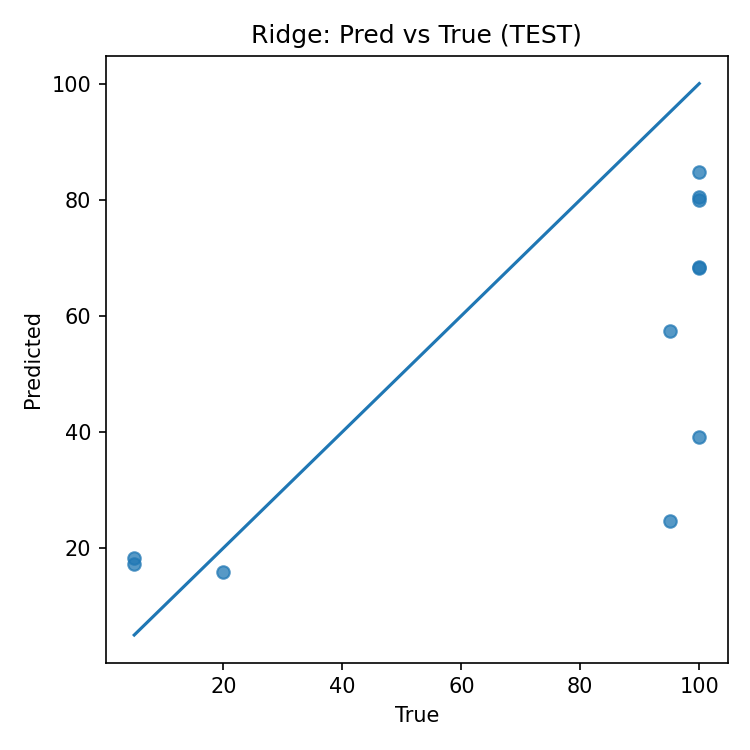

• 04_perm_importance_test_Ridge.png


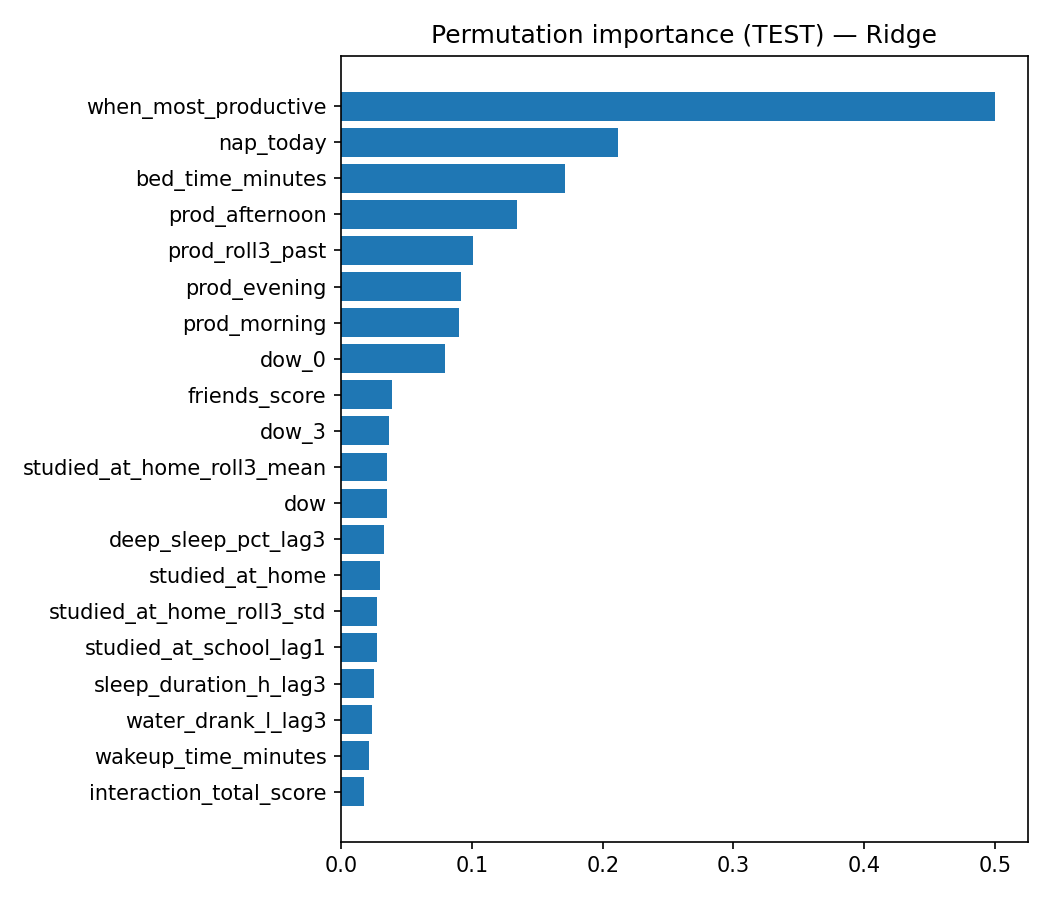

• 04_pdp_ice_Ridge_sleep_duration_h.png


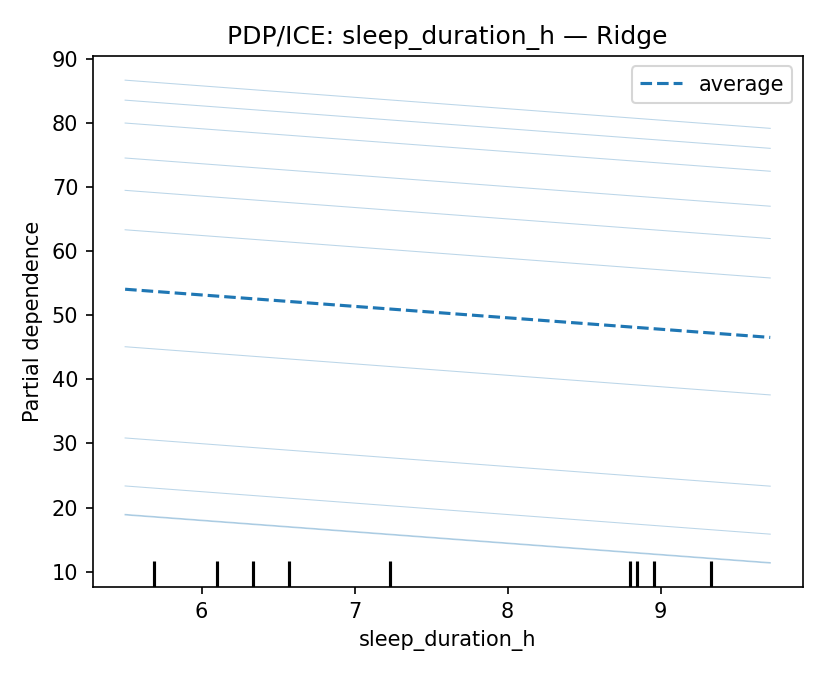

• 04_pdp_ice_Ridge_water_drank_l.png


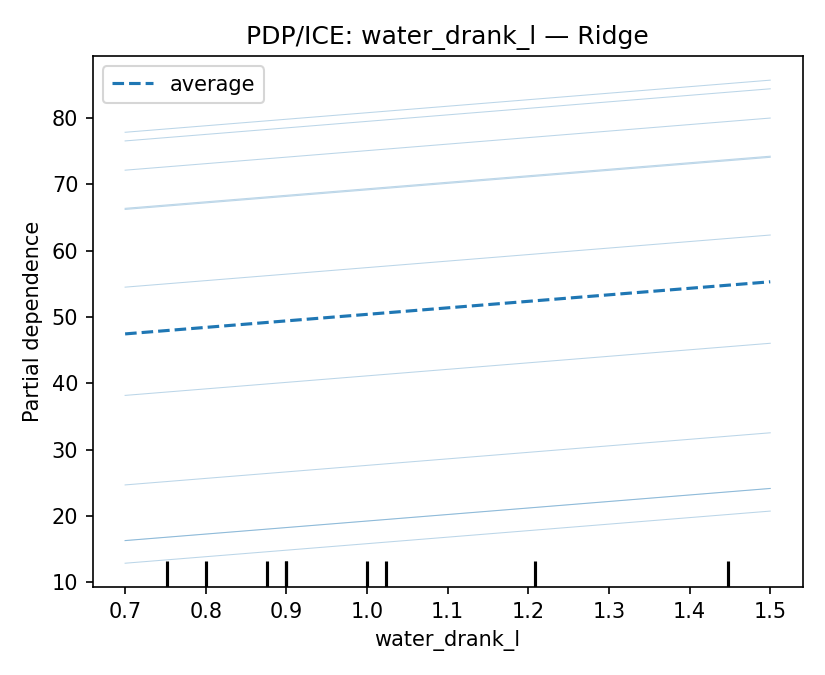

• 04_pdp_ice_Ridge_studied_at_home.png


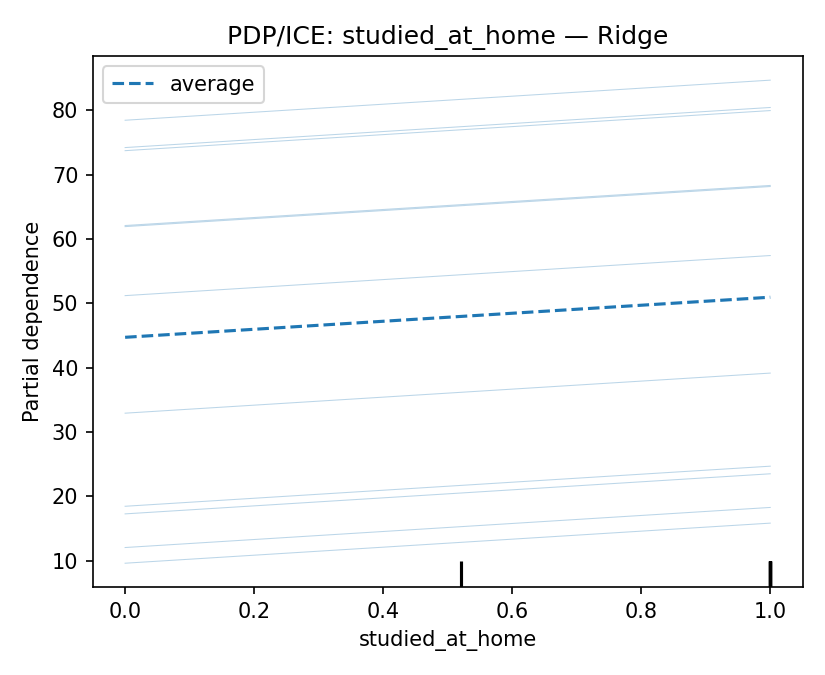

• 04_group_ablation_Ridge.png


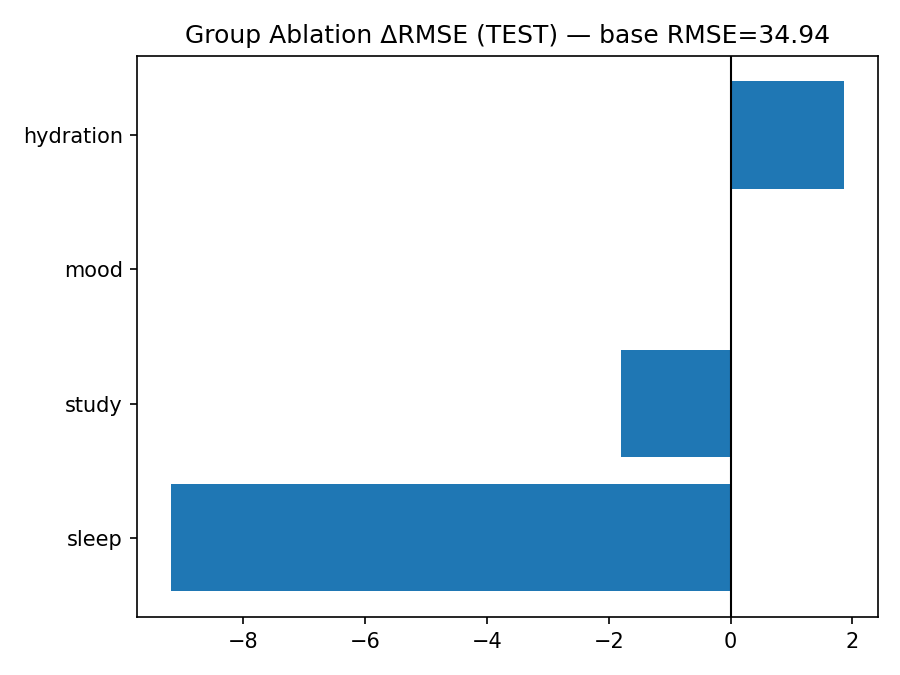

• 04_shap_beeswarm_Ridge.png


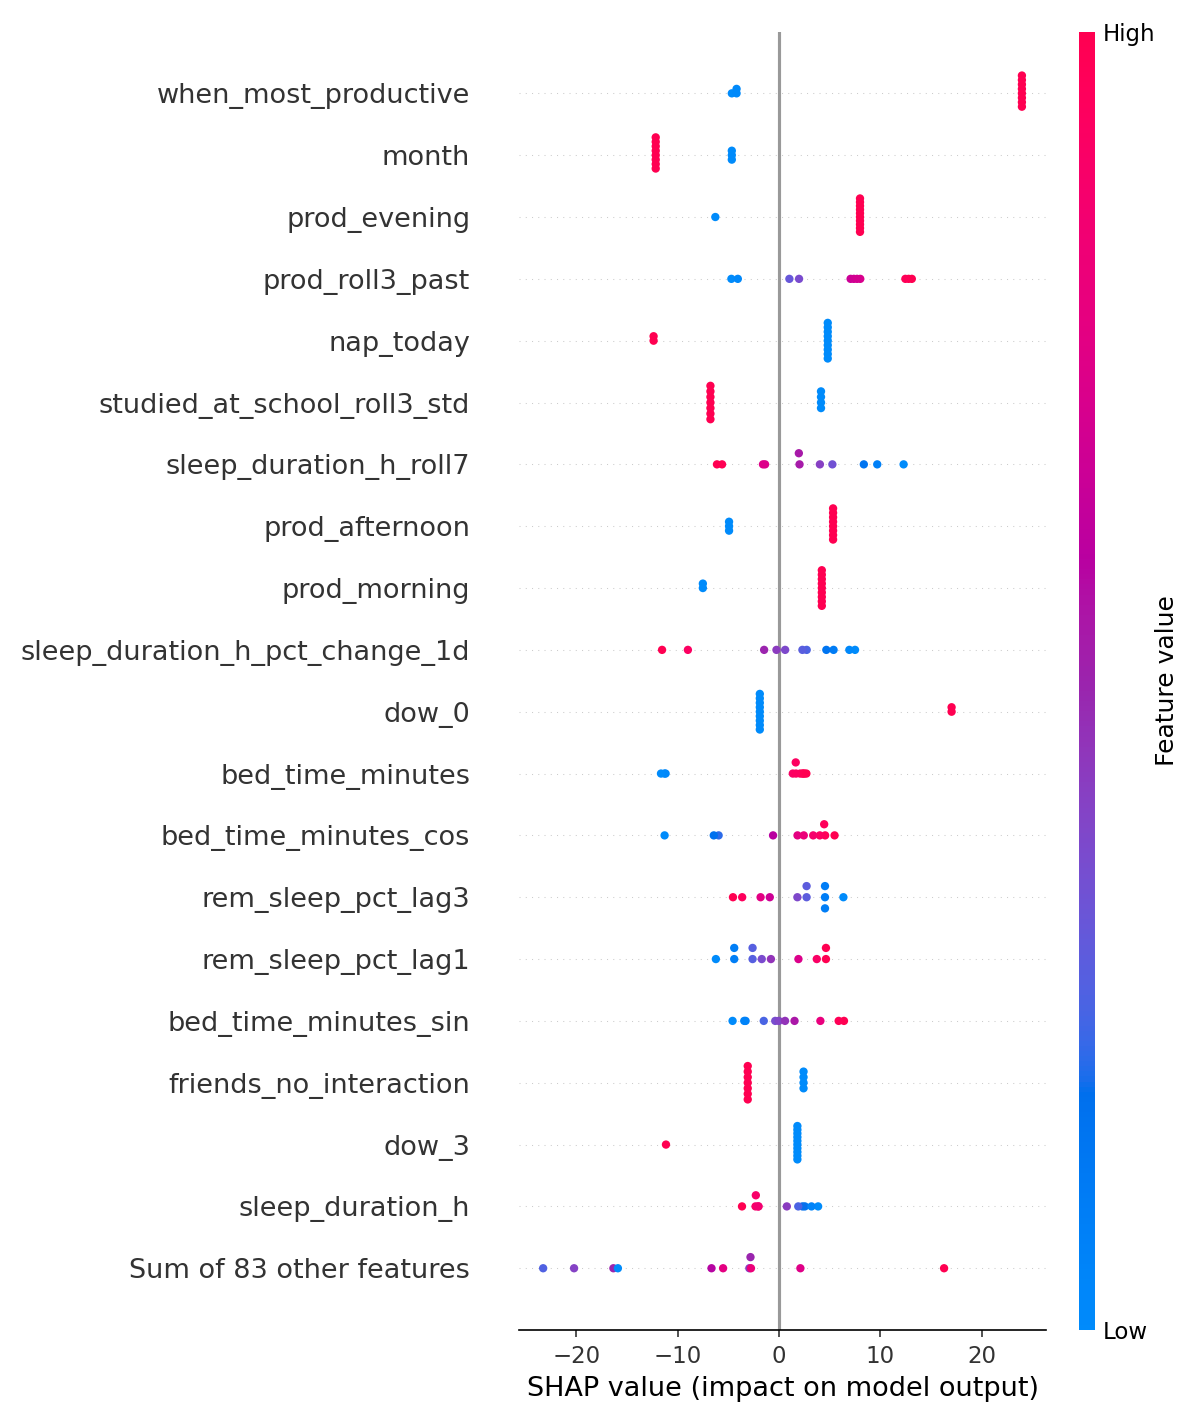

• 04_shap_waterfall_Ridge_last_test.png


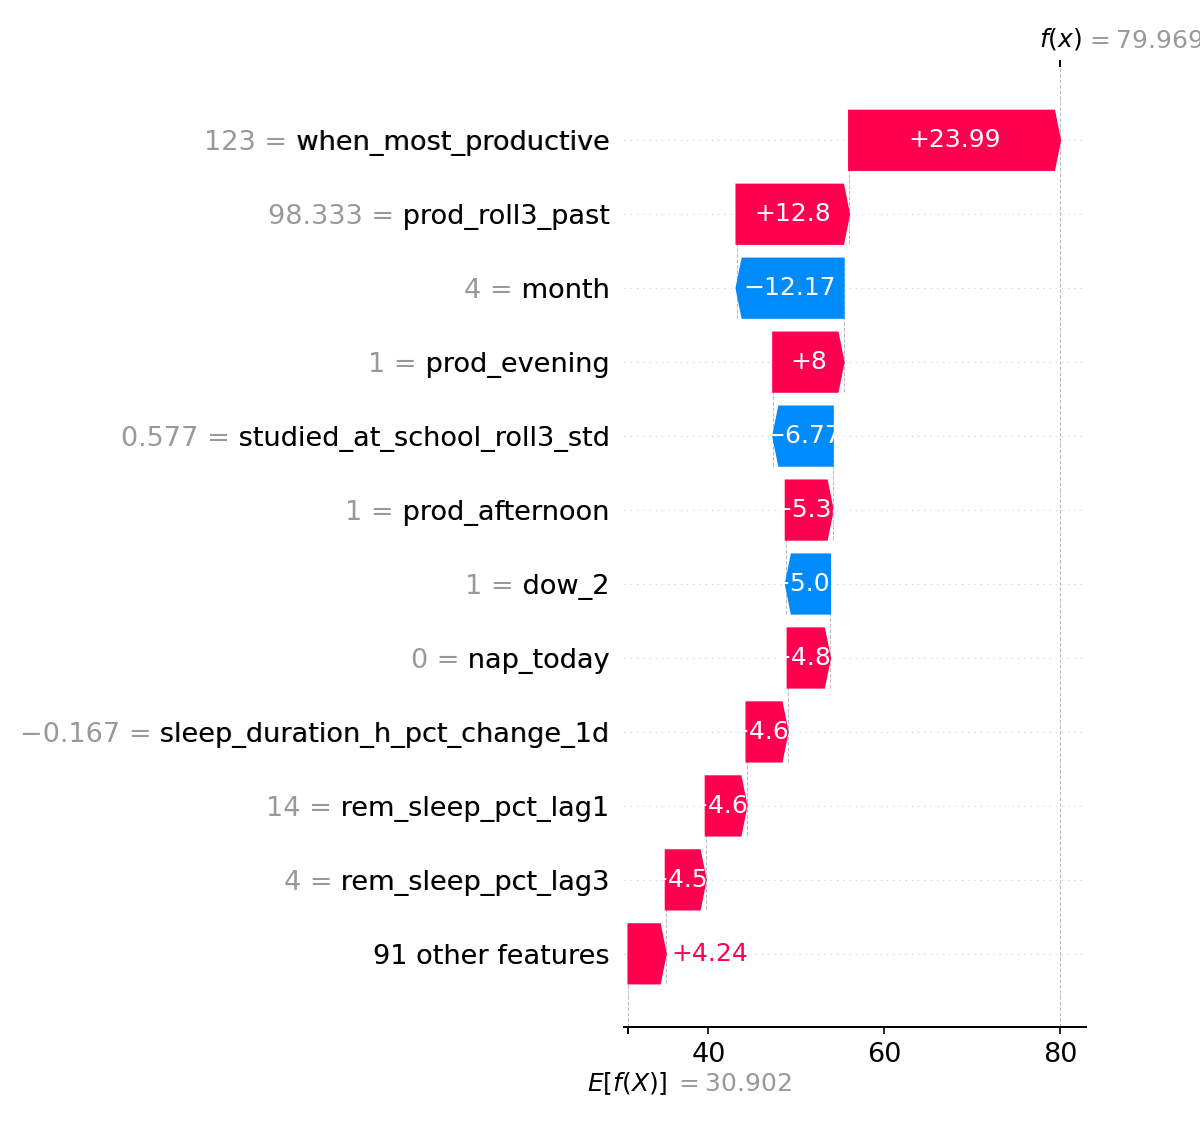

In [82]:
# Show only figures produced by this notebook (prefix "04_")
from IPython.display import display, Image
import glob, os, pandas as pd

pattern = str(FIGS / "04_*.png")
pngs = sorted(glob.glob(pattern), key=os.path.getmtime)

print(f"Found {len(pngs)} figure(s) for this notebook:")
for p in pngs:
    print("•", os.path.basename(p))
    display(Image(filename=p))


---

## What we did 
- Added **past-only** temporal context (lags & rolling means) and sanitized numerics.
- Time-aware **train/val/test** split (70/15/15).
- Fit **Ridge** and **GBR**; selected best on validation; evaluated on **TEST**.
- Generated **Permutation Importance**, **PDP/ICE**, **(optional) SHAP**, and **group ablations**.
- Ran a **leakage audit** and rebuilt any target-history features as **past-only**.

---

## Headline results
- **Best model:** `Ridge` (simpler model generalizes best on this small dataset).
- **Typical TEST error:** see `04_leaderboard.csv` (RMSE/MAE/R²).  
- **Checks:** Leakage audit passed — target history is **past-only**.  
- **Explainability:** 
  - *Permutation importance* highlights global drivers.
  - *PDP/ICE* shows how changing a behavior moves the prediction.
  - *SHAP (optional)* provides a why-this-day view (waterfall).

> Figures:  
> - Pred vs True (TEST): `04_pred_vs_true_test_<best>.png`  
> - Permutation importance: `04_perm_importance_test_<best>.png`  
> - PDP/ICE: `04_pdp_ice_<best>_<feature>.png`  
> - SHAP beeswarm/waterfall: `04_shap_*`  
> - Group ablations: `04_group_ablation_<best>.png`

---

## What matters (drivers)
*(Empirical from permutation importance / Ridge coefficients / SHAP)*
- **Productivity momentum (past-only):** 3–7-day history signals are informative (autocorrelation).  
- **Sleep duration & quality:** Longer sleep and stable patterns tend to increase predicted productivity.  
- **Hydration proxy:** Higher `water_drank_l` is mildly positive on average.  
- **Study context:** Having a planned study/home block often nudges predictions up.  
- **Calendar effects:** `dow/week_of_year/month` capture seasonality (keep if you want trend modeling; drop if you want behavior-only models).

---

## Actions (levers I can pull)
- **Sleep:** Target a consistent **bed/wake window**; prioritize ≥ *X* hours (see PDP for the knee).  
- **Hydration:** Set a **daytime water target** (PDP suggests diminishing returns after ~Y L).  
- **Planned focus blocks:** Schedule at least **one early block** (if `prod_morning` helps).  
- **Reduce variability:** Aim for **lower std** in key behaviors (sleep duration, study block) — consistency helps the model and the day.

> Use the PDP/ICE plots as “what-if” maps: given today’s plan, how much would +30-45 min sleep or +0.5 L water likely shift the prediction?

---

## Validation hygiene
- **Past-only** target history (`*_past`), verified low `r_future` in the leakage audit.  
- Numeric sanitization (inf → NaN → imputed).  
- Time-aware split; metrics reported on **held-out TEST**.

---

## Notes & Next
- Add lightweight **feature cards** (short text under each plot) for the 3 strongest drivers.  
- Try a small walk-forward with a **purge gap** (extra-conservative).  
- (Optional) Export model to `models/` and build a tiny **Streamlit** UI for live “what-if”.
